In [7]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class IsokineticOptimizer(Optimizer):
    def __init__(self, params, lr=0.01, c_init=1.0, c_scheduler=None, initial_velocity=None):
        defaults = dict(lr=lr, c_init=c_init, initial_velocity=initial_velocity)
        super(IsokineticOptimizer, self).__init__(params, defaults)
        self.c_scheduler = c_scheduler

    def projection(self, velocity, c):
        # In-place projection of the velocity to maintain kinetic energy
        kinetic_energy = 0.5 * torch.sum(velocity**2)
        scaling_factor = torch.sqrt(c / kinetic_energy)
        velocity.mul_(scaling_factor)  # In-place scaling of velocity
        return velocity

    def update_c(self, step):
        if self.c_scheduler:
            self.c_scheduler(self, step)

    def step(self, closure=None):
        raise NotImplementedError

class VelocityVerletIsokineticOptimizer(IsokineticOptimizer):

    def __init__(self, params, lr=0.01, c_init=1.0, c_scheduler=None, initial_velocity=None):
        super(VelocityVerletIsokineticOptimizer, self).__init__(params, lr=lr, c_init=c_init, c_scheduler=c_scheduler, initial_velocity=initial_velocity)

    def initvel(self, c_init, dim):
        sigma_squared = torch.tensor(2 * c_init / dim)
        sigma = torch.sqrt(sigma_squared)
        initial_velocity = torch.randn(dim) * sigma
        return initial_velocity

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        step = self.state.get('step', 0)  # Track the number of steps

        for group in self.param_groups:
            lr = group['lr']
            c = group['c_init']
            initial_velocity = group['initial_velocity']
            for param in group['params']:
                if param.grad is None:
                    continue
                
                # Ensure params and gradients are in float32 for memory efficiency
                param.data = param.data.float()
                force = -param.grad.data.float()

                if 'velocity' not in self.state:
                    self.state['velocity'] = {}
                if param not in self.state['velocity']:
                    param_dim = param.data.numel()
                    if initial_velocity is not None:
                        self.state['velocity'][param] = initial_velocity.clone().view_as(param.data)
                    else:
                        self.state['velocity'][param] = self.initvel(c, param_dim).view_as(param.data)
                
                velocity = self.state['velocity'][param]

                # Perform in-place updates to minimize memory usage
                with torch.no_grad():
                    velocity.add_(0.5 * lr * force)  # velocity_half in-place update
                    param.data.add_(lr * velocity)   # In-place update to param.data

                    if closure is not None:
                        loss = closure()

                    # Compute new forces and update velocity in place
                    force_new = -param.grad.data.float()
                    velocity.add_(0.5 * lr * force_new)  # Update the velocity in-place
                    self.projection(velocity, c)  # Apply in-place projection to velocity

                self.state['velocity'][param] = velocity

        self.update_c(step)
        self.state['step'] = step + 1

        return loss



# Toy Problem

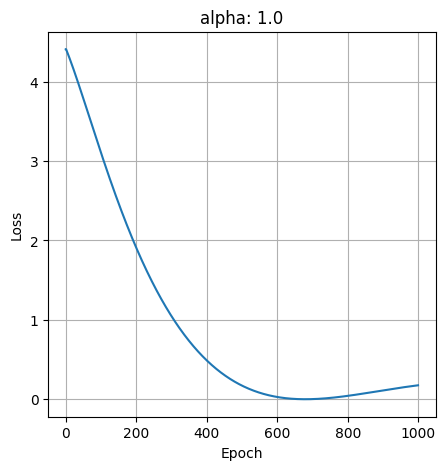

In [8]:
class QuadraticFunction(nn.Module):
    def __init__(self, A, b):
        super(QuadraticFunction, self).__init__()
        self.A = A
        self.b = b

    def forward(self, x):
        return 0.5 * x @ self.A @ x - self.b @ x

def reduce_c_scheduler_factory(alpha):
    def reduce_c_scheduler(optimizer, step):
        if step % 100 == 0:
            optimizer.param_groups[0]['c_init'] *= alpha
    return reduce_c_scheduler

coefficients = torch.tensor([0.999])
A = torch.tensor([[2.0, 0.0], [0.0, 2.0]], dtype=torch.float32)
b = torch.tensor([1.0, 1.0], dtype=torch.float32)
c_init = 1.0

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, coef in enumerate(coefficients):
    c_scheduler = reduce_c_scheduler_factory(coef)
    quadratic_function = QuadraticFunction(A, b)
    x = torch.tensor([2.1, 0.3], requires_grad=True)
    optimizer = VelocityVerletIsokineticOptimizer([x], lr=0.001, c_init=c_init, c_scheduler=c_scheduler)
    loss_values = []
    for epoch in range(1000):
        optimizer.zero_grad()
        loss = quadratic_function(x)**2
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    axs.plot(loss_values)
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.set_title(f'alpha: {round(coef.item(), 2)}')
    axs.grid(True)
plt.show()


# Neural Network

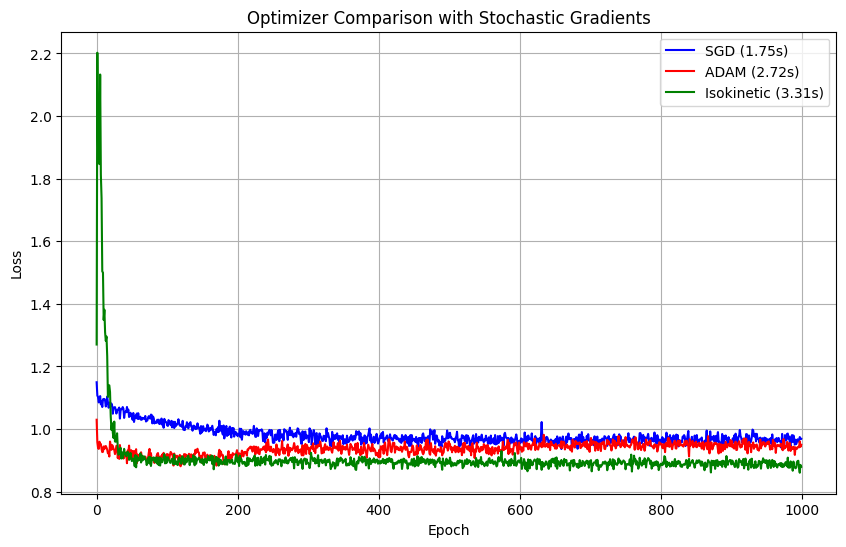

In [9]:
def reduce_c_scheduler(optimizer, step):
    optimizer.param_groups[0]['c_init'] *= 0.99

def run_experiment(optimizer_type, scheduler=None, batch_size = 64):  # Add batch_size as a parameter
    model = nn.Sequential(
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )

    criterion = nn.MSELoss()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.1)
    elif optimizer_type == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=0.1)
    elif optimizer_type == 'Isokinetic':
        c_init = 1.0
        optimizer = VelocityVerletIsokineticOptimizer(model.parameters(), lr=0.1, c_init=c_init, c_scheduler=scheduler)
    else:
        raise ValueError("Unsupported optimizer type")

    loss_values = []
    inputs = torch.randn(1000, 10)
    targets = torch.randn(1000, 1)

    for epoch in range(1000):
        perm = torch.randperm(inputs.size(0))
        inputs = inputs[perm]
        targets = targets[perm]
        
        epoch_loss = 0
        num_batches = inputs.size(0) // batch_size
        
        for i in range(num_batches):
            # Mini-batch
            batch_inputs = inputs[i*batch_size:(i+1)*batch_size]
            batch_targets = targets[i*batch_size:(i+1)*batch_size]
            
            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            
            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        loss_values.append(epoch_loss / num_batches)

    return loss_values

# Run experiments
start_time = time.time()
loss_sgd = run_experiment('SGD', batch_size=64)
time_sgd = time.time() - start_time

start_time = time.time()
loss_adam = run_experiment('ADAM', batch_size=64)
time_adam = time.time() - start_time

start_time = time.time()
loss_isokinetic = run_experiment('Isokinetic', scheduler = reduce_c_scheduler, batch_size=64)
time_isokinetic = time.time() - start_time

# Plot results with wallclock times
plt.figure(figsize=(10, 6))
plt.plot(loss_sgd, label=f'SGD ({time_sgd:.2f}s)', color='blue')
plt.plot(loss_adam, label=f'ADAM ({time_adam:.2f}s)', color='red')
plt.plot(loss_isokinetic, label=f'Isokinetic ({time_isokinetic:.2f}s)', color='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison with Stochastic Gradients')
plt.legend()
plt.grid(True)
plt.show()




# MNIST

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

def run_experiment(optimizer_type, scheduler=None, batch_size=64):  
    # Define the neural network model
    model = nn.Sequential(
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

    criterion = nn.CrossEntropyLoss()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.1)
    elif optimizer_type == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_type == 'Isokinetic':
        c_init = 1.0
        optimizer = VelocityVerletIsokineticOptimizer(model.parameters(), lr=0.1, c_init=c_init, c_scheduler=scheduler)
    else:
        raise ValueError("Unsupported optimizer type")

    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training
    train_loss_values = []
    for epoch in range(20):
        model.train()  # Set model to training mode
        epoch_loss = 0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        train_loss_values.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()  # Set model to evaluation mode
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(batch_targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute accuracy, precision, recall, and F1 score
    accuracy = 100. * (sum(1 for x, y in zip(all_predictions, all_targets) if x == y) / len(all_targets))
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    return train_loss_values, accuracy, precision, recall, f1


In [ ]:
# Run experiments
start_time = time.time()
train_loss_sgd, accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = run_experiment('SGD', batch_size=64)
time_sgd = time.time() - start_time

start_time = time.time()
train_loss_adam, accuracy_adam, precision_adam, recall_adam, f1_adam = run_experiment('ADAM', batch_size=64)
time_adam = time.time() - start_time

def reduce_c_scheduler(optimizer, step):
    optimizer.param_groups[0]['c_init'] *= 0.999

start_time = time.time()
train_loss_isokinetic, accuracy_isokinetic, precision_isokinetic, recall_isokinetic, f1_isokinetic = run_experiment('Isokinetic', scheduler=reduce_c_scheduler, batch_size=64)
time_isokinetic = time.time() - start_time

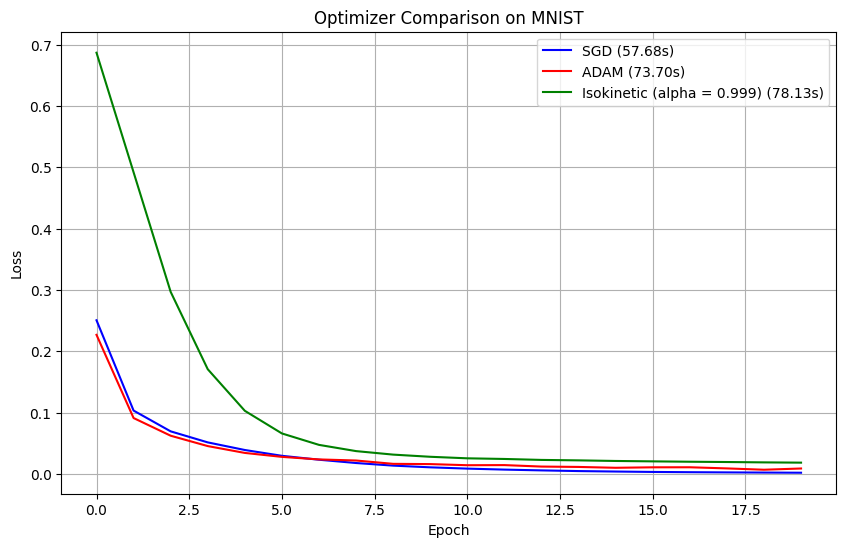

In [42]:
# Plot results with wallclock times
plt.figure(figsize=(10, 6))
plt.plot(train_loss_sgd, label=f'SGD ({time_sgd:.2f}s)', color='blue')
plt.plot(train_loss_adam, label=f'ADAM ({time_adam:.2f}s)', color='red')
plt.plot(train_loss_isokinetic, label=f'Isokinetic (alpha = 0.999) ({time_isokinetic:.2f}s)', color='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison on MNIST')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
print(f"SGD - Accuracy: {accuracy_sgd:.2f}%, Precision: {precision_sgd:.2f}%, Recall: {recall_sgd:.2f}%, F1-Score: {f1_sgd:.2f}%")
print(f"ADAM - Accuracy: {accuracy_adam:.2f}%, Precision: {precision_adam:.2f}%, Recall: {recall_adam:.2f}%, F1-Score: {f1_adam:.2f}%")
print(f"ISOK - Accuracy: {accuracy_isokinetic:.2f}%, Precision: {precision_isokinetic:.2f}%, Recall: {recall_isokinetic:.2f}%, F1-Score: {f1_isokinetic:.2f}%")

SGD - Accuracy: 98.34%, Precision: 0.98%, Recall: 0.98%, F1-Score: 0.98%
ADAM - Accuracy: 98.06%, Precision: 0.98%, Recall: 0.98%, F1-Score: 0.98%
ISOK - Accuracy: 96.65%, Precision: 0.97%, Recall: 0.97%, F1-Score: 0.97%
